<a href="https://colab.research.google.com/github/4juneko/Aiffel_work/blob/master/21_Compare_OCRmodel_06142023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rubric
|평가문항	|상세기준|내 평가|
|--|--|--|
|1. OCR을 활용하여 구현하려는 서비스의 기획이 타당한가?|	기획한 서비스가 OCR 적용 가능한 서비스이며,</br> OCR 기술을 활용했을 때 더 유용한지에 대한 타당성 여부를 기술하였다.|o|
|2. 모델 평가기준이 명확하고 체계적으로 세워졌는가?	|앞서 기획한 서비스에서 OCR 모델들이 그 목적에 부합하는지 확인하기 위해 </br>필요한 평가 기준을 제시하고, 평가기준에 적합한 테스트 데이터의 특징이 무엇인지 설명하였다.|o|
|3. 평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가?	|최대 20장까지의 테스트 이미지를 사용해</br>제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다.|o|

문자 모델은 보통 두 단계로 이뤄집니다.

먼저 입력받은 사진 속에서 문자의 위치를 찾아냅니다. 이 과정을 Text Detection(문자검출) 이라고 합니다. 찾은 문자 영역으로부터 문자를 읽어내는 것은 Text Recognition(문자인식) 입니다.

- 출처: https://brunch.co.kr/@kakao-it/318
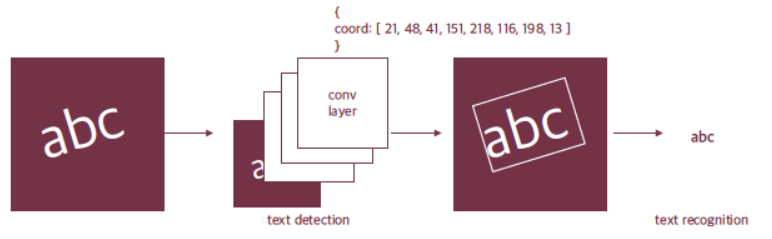

# Design Service
- 서비스 내용
시각 장애인들이 길을 다닐 때 길거리 표지판이나 간판을 인식을 하면 시각 장애인들이 길을 헤매지 않고 다른 사람의 도움을 받지 않고 정확한 위치를 찾는 데 도움이 될 거라 예상함.
- TTS와 인식한 간판이 현 위치에서 얼마나 떨어졌는지 알려준다면 더욱 유용한 서비스가 될 것임.
- 필요한 기능
    - 노이즈나 배치 문제에 강건한가
    - 가로 세로 글자 관계 없이 인식 가능한가
    - 거리가 먼 간판에 대해서도 인식 가능한가
    - 주변이 어두울 때 인식 가능한가
    - 여러 글자체 인식 가능한가



# Import Library

In [ ]:
import keras_ocr
import pytesseract

print(keras_ocr.__version__)
print(pytesseract.__version__)
# pytesseract는 tesseract-ocr에 종속적입니다. 아래 명령어를 통해 설치해야 할 수도 있습니다.
# !sudo apt install tesseract-ocr

0.8.8
0.3.8


In [ ]:
import glob
import os
import numpy as np
from PIL import Image

# 1 Dataset for Evaluation

## png to jpg
작업을 수월하게 확장자 통일

In [ ]:
def convert_png_to_jpg(path):
    # jpg파일을 저장하기 위한 디렉토리의 생성
#     if not os.path.exists(path+'_jpg'):
#         os.mkdir(path+'_jpg')

    # 모든 png 파일의 절대경로를 저장
    all_image_files=glob.glob(path+'/*.png')

    for file_path in all_image_files:                   # 모든 png파일 경로에 대하여
        img = Image.open(file_path).convert('RGB')  # 이미지를 불러온다.

        directories=file_path.split('/')                # 절대경로상의 모든 디렉토리를 얻어낸다.
#         directories[-2]+='_jpg'                     # 저장될 디렉토리의 이름 지정
        directories[-1]=directories[-1][:-4]+'.jpg'  # 저장될 파일의 이름 지정
        save_filepath='/'.join(directories)          # 절대경로명으로 바꾸기
        img.save(save_filepath, quality=100)       # jpg파일로 저장한다.
        os.remove(file_path)            # png 파일 지우기

In [ ]:
image_path= os.getenv('HOME')+'/aiffel/ocr_python/test_image/'
convert_png_to_jpg(image_path)

test_image

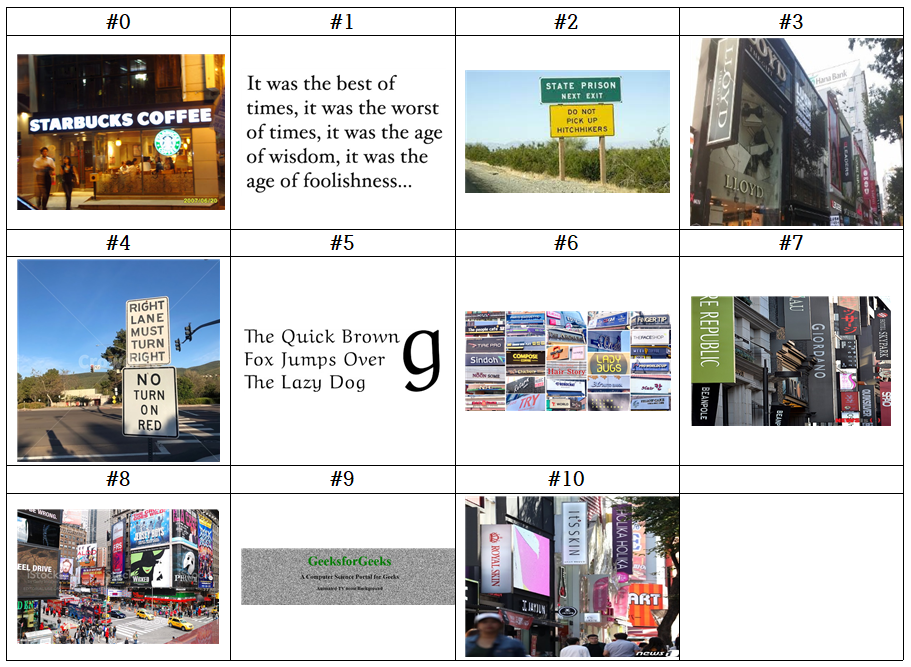

# 2 OCR(Optical Character Recognition, 광학 문자 인식) Test

## 2-1 keras-ocr

In [ ]:
!pip list | grep keras-ocr

keras-ocr                     0.8.8


In [ ]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다.
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [ ]:
# # url을 가진 경우

# image_urls = [
#   'https://source.unsplash.com/M7mu6jXlcns/640x460',
#   'https://source.unsplash.com/6jsp4iHc8hI/640x460',
#   'https://source.unsplash.com/98uYQ-KupiE',
#   'https://source.unsplash.com/j9JoYpaJH3A',
#   'https://source.unsplash.com/eBkEJ9cH5b4'
# ]

# images = [ keras_ocr.tools.read(url) for url in image_urls]
# prediction_groups = [pipeline.recognize([url]) for url in image_urls]

# url만 가능한지 알았는데 나중에 찾아보니 이미지 파일 경로를 넣도 되었던 거였음.

In [ ]:
# 이미지 파일을 가진 경우
# 이미지 리스트에 넣기
# https://thinking-developer.tistory.com/62

#변환할 이미지 목록 불러오기
image_path = os.getenv('HOME')+'/aiffel/ocr_python/test_image/'

img_list = os.listdir(image_path) #디렉토리 내 모든 파일 불러오기
img_list_jpg = [img for img in img_list if img.endswith(".jpg")] #지정된 확장자만 필터링

print ("img_list_jpg: {}".format(img_list_jpg))

img_list_jpg: ['9.jpg', '6.jpg', '7.jpg', '4.jpg', '0.jpg', '1.jpg', '10.jpg', '3.jpg', '2.jpg', '8.jpg', '5.jpg']


In [ ]:
img_list_np = []

for i in img_list_jpg:
    img = Image.open(image_path + i)
    img_array = np.array(img)
    img_list_np.append(img_array)
    print(i, " 추가 완료 - 구조:", img_array.shape)

9.jpg  추가 완료 - 구조: (223, 836, 3)
6.jpg  추가 완료 - 구조: (291, 600, 3)
7.jpg  추가 완료 - 구조: (718, 500, 3)
4.jpg  추가 완료 - 구조: (650, 650, 3)
0.jpg  추가 완료 - 구조: (375, 500, 3)
1.jpg  추가 완료 - 구조: (440, 700, 3)
10.jpg  추가 완료 - 구조: (743, 560, 3)
3.jpg  추가 완료 - 구조: (266, 302, 3)
2.jpg  추가 완료 - 구조: (174, 290, 3)
8.jpg  추가 완료 - 구조: (686, 1024, 3)
5.jpg  추가 완료 - 구조: (127, 398, 3)


In [ ]:
images = np.array(img_list_np) #리스트를 numpy로 변환
print(images.shape)

(11,)


/tmp/ipykernel_789/2084222469.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images = np.array(img_list_np) #리스트를 numpy로 변환


In [ ]:
images

array([array([[[187, 187, 187],
               [249, 249, 249],
               [ 57,  57,  57],
               ...,
               [238, 238, 238],
               [203, 203, 203],
               [ 88,  88,  88]],

              [[184, 184, 184],
               [176, 176, 176],
               [245, 245, 245],
               ...,
               [105, 105, 105],
               [238, 238, 238],
               [253, 253, 253]],

              [[131, 131, 131],
               [153, 153, 153],
               [246, 246, 246],
               ...,
               [193, 193, 193],
               [198, 198, 198],
               [ 77,  77,  77]],

              ...,

              [[ 53,  53,  53],
               [113, 113, 113],
               [200, 200, 200],
               ...,
               [222, 222, 222],
               [104, 104, 104],
               [102, 102, 102]],

              [[145, 145, 145],
               [197, 197, 197],
               [197, 197, 197],
               ...,
        

In [ ]:
prediction_groups = [pipeline.recognize([i]) for i in images]

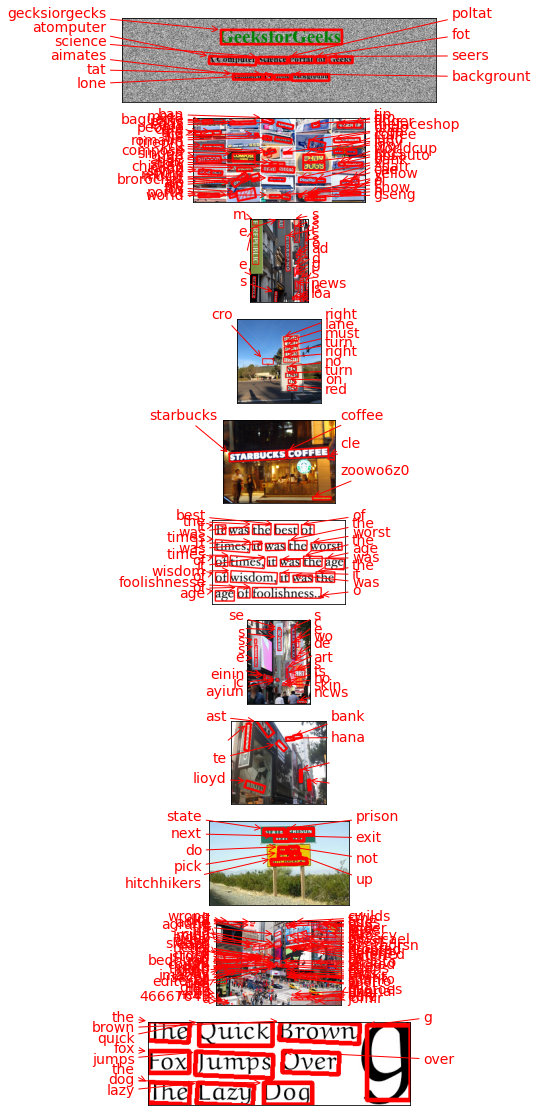

In [ ]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx],
                                    predictions=prediction_groups[idx][0], ax=ax)

|조건|인식 결과|
|--|--|
|가로로 된 간판| 잘 인식|
|세로로 된 간판| 오자 많음|
|작은 글씨| 별 문제 없음|
|정면 간판| 잘 인식 |
|옆에서 본 비뚤어진 간판| 오자가 많음.|
| 노이즈가 많은 글자|오자가 많음|

## 2-2 Tesseract

In [ ]:
# ! sudo apt install tesseract-ocr
# ! sudo apt install libtesseract-dev

In [ ]:
!pip list | grep pytesseract

pytesseract                   0.3.8


In [ ]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )

    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]

        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]

            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [ ]:
cropped_image_path_list={format(i):[] for i in range(15)}

In [ ]:
for i in range(11):
    try:
        work_dir = os.getenv('HOME')+'/aiffel/ocr_python/output/' + str(i)   # directory to save crop image
        img_file_path = os.getenv('HOME')+'/aiffel/ocr_python/test_image/' + str(i) + '.jpg'

        cropped_image_path_list[i] = crop_word_regions(img_file_path, work_dir)
    except SystemError:
        print('\033[31m \033[43m' + '#'+str(i)+' image  Error' + '\033[0m')
        pass

# 이미지 중에 crop이 안되고 오류인 것이 있음. 11번 이미지는 길거리 간판이 많은 이미지임.

/aiffel/aiffel/ocr_python/output/0/0000.png
/aiffel/aiffel/ocr_python/output/0/0001.png
/aiffel/aiffel/ocr_python/output/0/0002.png
/aiffel/aiffel/ocr_python/output/0/0003.png
/aiffel/aiffel/ocr_python/output/0/0004.png
/aiffel/aiffel/ocr_python/output/0/0005.png
/aiffel/aiffel/ocr_python/output/0/0006.png
/aiffel/aiffel/ocr_python/output/0/0007.png
/aiffel/aiffel/ocr_python/output/0/0008.png
/aiffel/aiffel/ocr_python/output/0/0009.png
/aiffel/aiffel/ocr_python/output/0/0010.png
/aiffel/aiffel/ocr_python/output/0/0011.png
/aiffel/aiffel/ocr_python/output/0/0012.png
/aiffel/aiffel/ocr_python/output/0/0013.png
/aiffel/aiffel/ocr_python/output/0/0014.png
/aiffel/aiffel/ocr_python/output/0/0015.png
/aiffel/aiffel/ocr_python/output/1/0000.png
/aiffel/aiffel/ocr_python/output/1/0001.png
/aiffel/aiffel/ocr_python/output/1/0002.png
/aiffel/aiffel/ocr_python/output/1/0003.png
/aiffel/aiffel/ocr_python/output/1/0004.png
/aiffel/aiffel/ocr_python/output/1/0005.png
/aiffel/aiffel/ocr_python/output

이미지 7, 9, 10이 크롭할 때 에러
세로 글자 간판과 노이즈가 많이 있는 이미지 였음.

In [ ]:
# ! sudo apt install tesseract-ocr-kor # install korean

In [ ]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    text_list=[]
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        text_list.append(recognized_data["text"].replace("\x0c","").replace("\n","")) #*\n,\f,\v

    return text_list
#     print("Done")


In [ ]:
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
for i in range(15):
    try:
        print('_'*15)
        print('\033[31m \033[43m' + '#'+str(i)+' image' + '\033[0m')
        a= recognize_images(cropped_image_path_list[i])
        print(a)
    except KeyError:
        pass

_______________
 #0 image
['~~', '7~', 'ie', 'ti', 'ae', 'ct', '_ a', '', '', 'et', 'al', ':', 'ae', 'oj', 'aol', 'a']
_______________
 #1 image
['It', 'Was', 'the', 'best', 'ot', 'times,', 'it', 'Was', 'the', 'Worst', 'ot', 'times,', '1t', 'WAS', 'the', 'ALC', 'ot', 'wisdom,', '1t', 'WaSs', 'the', 'ALC', 'oft', 'foolishness...']
_______________
 #2 image
['a', 'STATE FPRISUN', 'NEXT EXIT', '_', '|', '—']
_______________
 #3 image
['Jy ‘']
_______________
 #4 image
['= 3 bs |']
_______________
 #5 image
['The', 'Ouick', 'brown.', 'Fox', 'Jumps', '()ver', 'The', 'Lazy', 'Uog']
_______________
 #6 image
['', '', '', 'ed ST', 'Yon', '| cle', '~', '“it', '"a', '', '’', '', 'é', 'll', 'Bnceun couegse —_', 'aoc', '==', '']
_______________
 #7 image
_______________
 #8 image
['']
_______________
 #9 image
_______________
 #10 image
_______________
 #11 image
_______________
 #12 image
_______________
 #13 image
_______________
 #14 image


- 간판 이미지 중에 제대로 읽은 글자가 거의 없음.
- 글자를 인식한 이미지는 간판이 아니라 비교를 위해 넣은 이미지 였음.
- 길거리 글자 인식을 위해서는 이 모델은 적합하지 않음.

## 2-3 Google OCR

In [ ]:
# !pip install --upgrade google-api-python-client
# !pip install google-cloud-vision

In [ ]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()

    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [ ]:
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다.
# 클라우드 환경에서는 무시해도 좋습니다
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# 입력 이미지 경로를 지정해 주세요.
# (예시) path = os.getenv('HOME')+'/aiffel/ocr_python/test_image.png'
# path = os.getenv('HOME')+'/aiffel/ocr_python/test.jpg'

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
for i in range(11):
    print('_'*15)
    print('\033[31m \033[43m' + '#'+str(i)+' image' + '\033[0m')
    path = os.getenv('HOME')+'/aiffel/ocr_python/test_image/' + str(i) +'.jpg'
    detect_text(path)

total 7112
-rw-r--r--  1 root root   68953 Jun 14 05:27 0000.png
-rw-r--r--  1 root root  220586 Jun 14 05:27 0001.png
-rw-r--r--  1 root root  215150 Jun 14 05:27 0002.png
-rw-r--r--  1 root root    2840 Jun 14 05:27 0003.png
-rw-r--r--  1 root root 4942967 Jun 14 05:27 0004.png
-rw-r--r--  1 root root  566988 Jun 20 07:53 Compare_OCRmodel_06142023.ipynb
drwxr-xr-x  2 root root    4096 Jun 14 05:26 crop
-rw-r--r--  1 root root    2346 Jun 16 02:04 my_google_api_key.json
-rw-r--r--  1 root root  436771 Jun 15 01:39 OCR_06142023.ipynb
drwxr-xr-x 18 root root    4096 Jun 15 07:39 output
drwxr-xr-x  3 root root    4096 Jun 20 07:14 test_image
-rw-r--r--  1 root root  800616 Jun 14 05:26 test.jpg
_______________
 #0 image
Texts:

"STARBUCKS COFFEE
248
2007/06/20"

"STARBUCKS"

"COFFEE"

"248"

"2007/06/20"
bounds: (400,346),(479,346),(479,357),(400,357)
_______________
 #1 image
Texts:

"It was the best of
times, it was the worst
of times, it was the age
of wisdom, it was the
age of foolis

- 3 모델 중에 오자가 가장 적음.

|조건|인식 결과|
|--|--|
|가로로 된 간판| 잘 인식|
|세로로 된 간판| 잘 인식|
|작은 글씨| 별 문제 없음|
|정면 간판| 잘 인식 |
|옆에서 본 비뚤어진 간판| 잘 익식.|
| 노이즈가 많은 글자|잘 인식|

# Review

|조건|Keras-OCR|Tesseract|Google OCR|
|--|--|--|--|
|가로로 된 간판| O|X|O|
|세로로 된 간판| X|X|O|
|작은 글씨| O|X|O|
|정면 간판| O |O|O|
|옆에서 본 비뚤어진 간판| X|X|O|
| 노이즈가 많은 글자|X|X|O|
|다양한 글자체 인식|O|X|O|

</br>

- 시각 장애인을 위한 길거리 간판의 글자 인식 서비스에 적합한 OCR model은 Google OCR이라고 판단됨.
- 서비스에서 필요한 모든 기능을 만족하는 결과를 얻었음.

</br>

- for문을 사용하여 여러 이미지를 한꺼번에 작업을 하였음. 내가 사랑하는 for

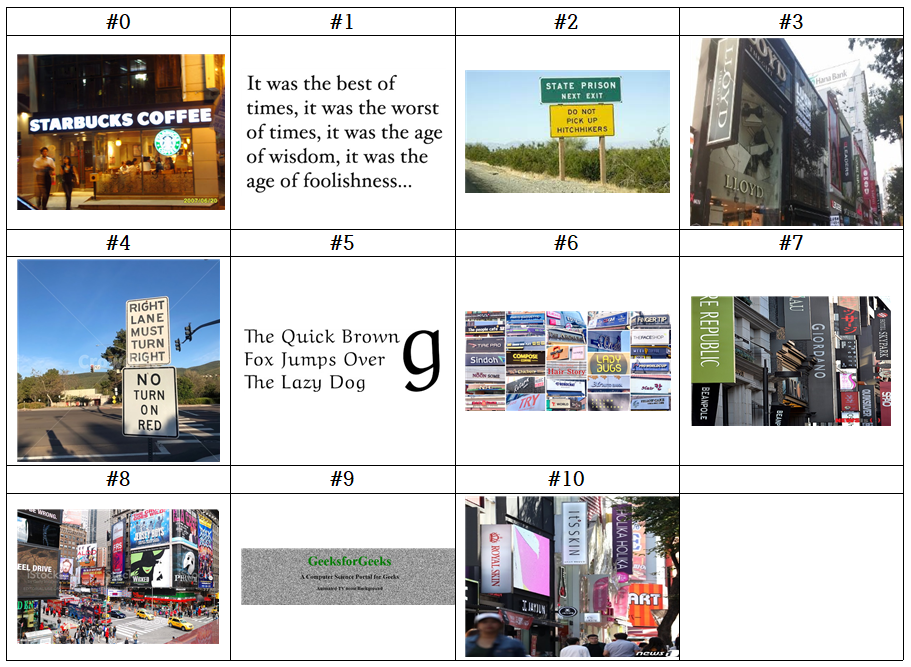